<a href="https://colab.research.google.com/github/AdamFulton/thesis/blob/main/time_series_1Dcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Apr 28 06:18:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import files
files=files.upload()

Saving AAPL.csv to AAPL.csv


In [ ]:
df = pd.read_csv("AAPL.csv")

df1 = df.reset_index()['close']

In [ ]:
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


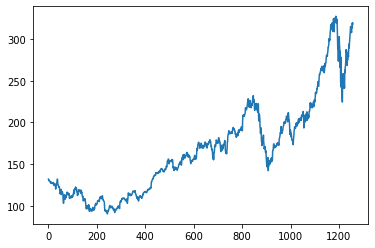

In [ ]:
plt.plot(df1)

In [ ]:
scalar = MinMaxScaler(feature_range=(0,1))
df1 = scalar.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
training_size=int(len(df1)*0.60)
validate_size = int(len(df1)*0.20)
test_size=len(df1)-training_size + validate_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
class StockDataset(Dataset):
    def __init__(self,data,seq_len = 100):
        self.data = data
        self.data = torch.from_numpy(data).float().view(-1)
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.data)-self.seq_len-1

    def __getitem__(self, index) :
        return  self.data[index : index+self.seq_len] , self.data[index+self.seq_len]


train_dataset = StockDataset(train_data) 
test_dataset = StockDataset(test_data)

In [ ]:
batch_size = 64
train_dataloader = DataLoader(train_dataset,batch_size,drop_last=True)
test_dataloader = DataLoader(test_dataset,batch_size , drop_last=True)

device = "cuda" if torch.cuda.is_available() else "cpu"


for i, j in train_dataloader:

  print(i.shape)
  break

torch.Size([64, 100])


In [ ]:
class CNN(nn.Module):
    """Model for human-activity-recognition."""
    def __init__(self, input_size, num_classes):
        super().__init__()

       
        self.features = nn.Sequential(
            nn.Conv1d(input_size, 64, 1),
            nn.MaxPool1d(1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv1d(64, 64, 1),
             nn.MaxPool1d(1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv1d(64, 64, 1),
            nn.MaxPool1d(1),
            nn.ReLU(),
            )
     
        self.classifier = nn.Sequential(
        	nn.Dropout(),
        	nn.Linear(6400,3200),
        	nn.ReLU(),
        	nn.Dropout(),
          nn.Linear(3200,100),
        	nn.ReLU(),
        	nn.Dropout(),
        	nn.Linear(100,1),
        	)

    def forward(self, x):
      x = self.features(x)
      x = torch.flatten(x)
     
      out = self.classifier(x)

      return out

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv1d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm1d(oup),
                nn.LeakyReLU(0.01, inplace=True),
            )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                nn.Conv1d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout(p=0.01),
                nn.BatchNorm1d(inp),
              
    
                nn.Conv1d(inp, oup, 1, 1, 0, bias=False),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout(p=0.01),
                nn.BatchNorm1d(oup)
               
            )

        self.model = nn.Sequential(
            conv_bn(  100,  100, 2), 
            conv_dw( 100,  128, 1),
            conv_dw( 128, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AvgPool1d(1),
        )

        self.classifier = nn.Sequential(
        nn.Linear(1024, 512),
      	nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64,1)

        )
    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.classifier(x)
        return x

In [ ]:
def get_default_device():

  if torch.cuda.is_available():
    return torch.device("cuda")

  else:
    return torch.device("cpu")

In [ ]:
device = get_default_device();
device

device(type='cuda')

In [ ]:
def to_device(data,device):

  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]

  return data.to(device,non_blocking=True)

In [ ]:
for images,labels in train_dataloader:
  images = to_device(images,device)



In [ ]:
class DeviceDataLoader():
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
       
        return len(self.dl)

In [ ]:
train_dataloader  = DeviceDataLoader(train_dataloader,device)
model = Net()
to_device(model,device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
epochs = 100

for i in range(epochs):
    
    model.train()
    for seq, labels in train_dataloader:
        optimizer.zero_grad()

        y_pred = model(seq.reshape(64,100,1))
  

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()        
        optimizer.step()


      
             


    


    
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    
  

       

        



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   0 loss: 0.00981043
epoch:   1 loss: 0.03968986
epoch:   2 loss: 0.03697047
epoch:   3 loss: 0.03217779
epoch:   4 loss: 0.03003521
epoch:   5 loss: 0.02973117
epoch:   6 loss: 0.02902727
epoch:   7 loss: 0.02861162
epoch:   8 loss: 0.02789665
epoch:   9 loss: 0.02885000
epoch:  10 loss: 0.02689986
epoch:  11 loss: 0.02445438
epoch:  12 loss: 0.02529297
epoch:  13 loss: 0.02360248
epoch:  14 loss: 0.02401728
epoch:  15 loss: 0.02118811
epoch:  16 loss: 0.01707762
epoch:  17 loss: 0.01819707
epoch:  18 loss: 0.01914334
epoch:  19 loss: 0.00833166
epoch:  20 loss: 0.00473871
epoch:  21 loss: 0.00758413
epoch:  22 loss: 0.01007567
epoch:  23 loss: 0.04296130
epoch:  24 loss: 0.00649799
epoch:  25 loss: 0.01490202
epoch:  26 loss: 0.00570328
epoch:  27 loss: 0.00394466
epoch:  28 loss: 0.00424501
epoch:  29 loss: 0.01529303
epoch:  30 loss: 0.00400660
epoch:  31 loss: 0.00764670
epoch:  32 loss: 0.00233661
epoch:  33 loss: 0.00556756
epoch:  34 loss: 0.00467946
epoch:  35 loss: 0.0

In [ ]:
import math
from sklearn.metrics import mean_squared_error
import numpy as np
def calculate_metrics(data_loader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
      
        for batch , item in enumerate(data_loader):
            x , y = item
            x , y = x.to(device) , y.to(device)
            x = x.view(64,100,1)
            pred = model(x)
          
            pred = scalar.inverse_transform(pred.detach().cpu().numpy())
          
            y = scalar.inverse_transform(y.detach().cpu().numpy().reshape(1,-1)).reshape(-1)
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)
       
        return math.sqrt(mean_squared_error(y_arr,pred_arr))

In [ ]:
print(f"train mse loss {calculate_metrics(train_dataloader)}")

train mse loss 7.267113842751854
